In [344]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [345]:
# Set device to cuda
torch.set_default_tensor_type("torch.cuda.FloatTensor")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)
print(torch.cuda.is_available())


12.1
True


In [346]:
# Load and normalize the data
df = pd.read_csv('../data/Reversed_S&P500_5_years.csv', usecols=['Close/Last', 'Open', 'High', 'Low'])

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df)

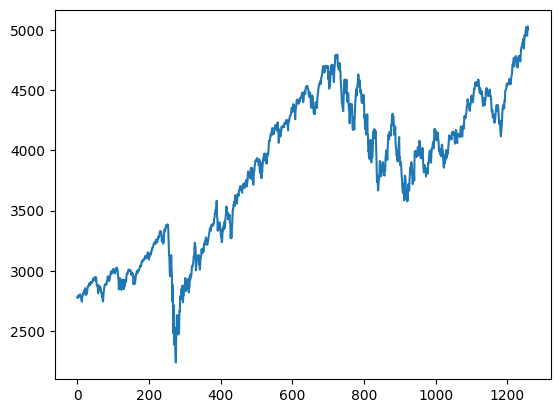

In [347]:
timeseries = df[["Close/Last"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

In [348]:
# Function to create sequences
def create_sequences(data, look_back_days):
    xs, ys = [], []
    # for i in range(len(data) - look_back_days - 1, -1, -1):
    for i in range(len(data)-look_back_days - 1):
        x = data[i : (i + look_back_days)]
        y = data[i + look_back_days][0]  # Predict next close value
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [349]:
# ORIGINAL CODE

# Separate data

# look_back_days = 10  # Number of time steps to look back
# X, y = create_sequences(scaled_data, look_back_days)
# X_train, y_train = torch.FloatTensor(X), torch.FloatTensor(y)




### Testing

In [350]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = scaled_data[:train_size], scaled_data[train_size:]
print(train_size)

843


In [351]:
look_back_days = 5
X_train, y_train = create_sequences(train, look_back_days)
X_test, y_test = create_sequences(test, look_back_days)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train, y_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train)
X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

(837, 5, 4) (837,)
(410, 5, 4) (410,)


In [352]:
# DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=1, drop_last=True, generator=torch.Generator(device='cuda'),)

In [353]:
class StockLSTM(nn.Module):
    def __init__(self, input_size=4*look_back_days, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size, device=device),
                            torch.zeros(1,1,self.hidden_layer_size, device=device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [354]:

model = StockLSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [355]:


epochs = 300 # 150
for i in range(epochs):
    model.to(device)
    model.train()
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)
        
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size, device=device),
                             torch.zeros(1, 1, model.hidden_layer_size, device=device))

        y_pred = model(seq)
        # print(y_pred, labels)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i % 25 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        #
        #
        #
        model.eval()
        with torch.no_grad():
            y_pred_train  = model(X_train)
            train_rmse = torch.sqrt(loss_function(y_pred_train, y_train))
            y_pred_test  = model(X_test)
            test_rmse = torch.sqrt(loss_function(y_pred_test, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (i, train_rmse, test_rmse))
        #
        #
        #


epoch:   0 loss: 0.00340878
Epoch 0: train RMSE 0.5092, test RMSE 0.8987


c:\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([837])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([410])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:  25 loss: 0.00012058
Epoch 25: train RMSE 0.4868, test RMSE 0.7825
epoch:  50 loss: 0.00283478
Epoch 50: train RMSE 0.5029, test RMSE 0.8319
epoch:  75 loss: 0.00158118
Epoch 75: train RMSE 0.4895, test RMSE 0.7733
epoch: 100 loss: 0.00519448
Epoch 100: train RMSE 0.4948, test RMSE 0.8082
epoch: 125 loss: 0.00023875
Epoch 125: train RMSE 0.4818, test RMSE 0.7826
epoch: 150 loss: 0.00082970
Epoch 150: train RMSE 0.4865, test RMSE 0.7851
epoch: 175 loss: 0.00010622
Epoch 175: train RMSE 0.4799, test RMSE 0.7304
epoch: 200 loss: 0.00029406
Epoch 200: train RMSE 0.4828, test RMSE 0.7673


In [ ]:
def create_sequences_for_eval(data, look_back_days):
    xs = []
    for i in range(len(data) - look_back_days - 1, -1, -1):
        x = data[i : (i + look_back_days)]
        xs.append(x)
    return np.array(xs)


In [ ]:
df[-11:]

,Close/Last,Open,High,Low
1248,4958.61,4916.06,4975.29,4907.99
1249,4942.81,4957.19,4957.19,4918.09
1250,4954.23,4950.16,4957.77,4934.88
1251,4995.06,4973.05,4999.89,4969.05
1252,4997.91,4995.16,5000.40,4987.09
1253,5026.61,5004.17,5030.06,5000.34
1254,5021.84,5026.83,5048.39,5016.83
1255,4953.17,4967.94,4971.30,4920.31
1256,5000.62,4976.44,5002.52,4956.45
1257,5029.73,5003.14,5032.72,4999.44


In [ ]:
recent_seq_scaled  = create_sequences_for_eval(scaled_data[-11:], look_back_days)
recent_seq_tensor  = torch.FloatTensor(recent_seq_scaled)

if torch.cuda.is_available():
    recent_seq_tensor  = recent_seq_tensor.to('cuda')

In [ ]:
print(recent_seq_tensor)

tensor([[[0.9978, 0.9803, 0.9867, 0.9883],
         [0.9943, 0.9969, 1.0000, 1.0000],
         [0.9452, 0.9539, 0.9439, 0.9317],
         [0.9792, 0.9601, 0.9666, 0.9573],
         [1.0000, 0.9796, 0.9886, 0.9877]],

        [[0.9772, 0.9737, 0.9651, 0.9789],
         [0.9978, 0.9803, 0.9867, 0.9883],
         [0.9943, 0.9969, 1.0000, 1.0000],
         [0.9452, 0.9539, 0.9439, 0.9317],
         [0.9792, 0.9601, 0.9666, 0.9573]],

        [[0.9752, 0.9576, 0.9647, 0.9662],
         [0.9772, 0.9737, 0.9651, 0.9789],
         [0.9978, 0.9803, 0.9867, 0.9883],
         [0.9943, 0.9969, 1.0000, 1.0000],
         [0.9452, 0.9539, 0.9439, 0.9317]],

        [[0.9459, 0.9409, 0.9340, 0.9420],
         [0.9752, 0.9576, 0.9647, 0.9662],
         [0.9772, 0.9737, 0.9651, 0.9789],
         [0.9978, 0.9803, 0.9867, 0.9883],
         [0.9943, 0.9969, 1.0000, 1.0000]],

        [[0.9377, 0.9460, 0.9336, 0.9301],
         [0.9459, 0.9409, 0.9340, 0.9420],
         [0.9752, 0.9576, 0.9647, 0.9662],
   

In [ ]:
# prediction = model(X_test)
with torch.no_grad():
    
    prediction_scaled = model(recent_seq_tensor)
    prediction = prediction_scaled.cpu().numpy() 
    print("Finish")
    print(prediction)


Finish
[1.3688743]


In [ ]:
# Assuming 'prediction' is your model's output with shape (1,1)
# Create a dummy array with the shape (1, number_of_features)
dummy_input = np.zeros((1, 4))  # 4 features for 'Close/Last', 'Open', 'High', 'Low'
dummy_input[0, 0] = prediction  # Replace the first value with your prediction

# Perform inverse transformation
predicted_stock_price_scaled = scaler.inverse_transform(dummy_input)[0, 0]

print(f"Predicted stock price: {predicted_stock_price_scaled}")


Predicted stock price: 5544.739403041601


In [ ]:
print(prediction)

[1.3688743]


843 837
[3299.433093149736, 2790.724514031112, 2557.3515110608932, 2450.1064153435823, 2405.2524563786383, 2379.822058986127, 2363.111401568949, 2345.358855807483, 2319.8944222861523, 2289.567316111326, 2302.6170508414502, 2335.5935658994313, 2360.185542759299, 2371.9093663880226, 2383.733467608988, 2396.460816121399, 2404.858585968613, 2399.599796021282, 2403.3990268895027, 2392.400280987918, 2363.7733168956634, 2358.544901488721, 2368.943146887719, 2362.8510959187147, 2381.333962136209, 2417.78041475743, 2439.22783611685, 2451.784504677653, 2457.8725611865516, 2470.2979950892923, 2479.2198713895673, 2470.472835936844, 2467.6461728864906, 2471.9095100882646, 2487.1576125812526, 2495.615465765893, 2500.2214111396665, 2498.2687858912345, 2495.2990712383385, 2495.2168519344923, 2511.7849570566414, 2525.3936665478345, 2525.017854426205, 2526.424154037237, 2541.634808466732, 2546.056176496446, 2535.2295252510903, 2519.722365376651, 2525.975110146999, 2528.869429365396, 2486.9461558493967, 

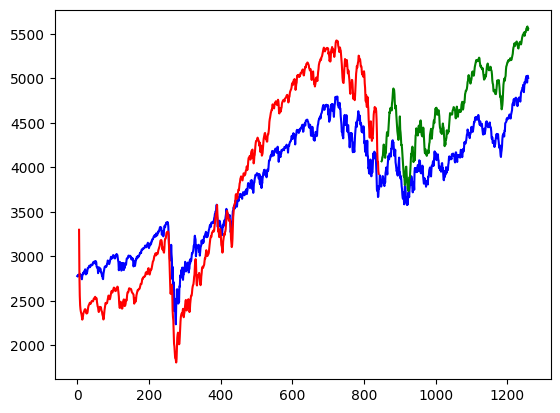

In [ ]:

print(train_size, len(X_train))
# train_size = len(X_train)
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_line = []
    for i in X_train:
        prediction = model(i.reshape(1, look_back_days, 4)).cpu().numpy()
        dummy_input = np.zeros((1, 4))  # 4 features for 'Close/Last', 'Open', 'High', 'Low'
        dummy_input[0, 0] = prediction  # Replace the first value with your prediction
        predicted_stock_price_scaled = scaler.inverse_transform(dummy_input)[0, 0]
        y_line.append(predicted_stock_price_scaled)
    print(y_line)
    print(len(y_line))
    y_line = np.array(y_line)
    y_line = y_line.reshape(-1, 1)

    train_plot[look_back_days:train_size-1] = y_line #model(X_train).cpu().numpy()#[:, -1, :]
    # shift test predictions for plotting
    
    y_test_line = []
    for i in X_test:
        prediction = model(i.reshape(1, look_back_days, 4)).cpu().numpy()
        dummy_input = np.zeros((1, 4))  # 4 features for 'Close/Last', 'Open', 'High', 'Low'
        dummy_input[0, 0] = prediction  # Replace the first value with your prediction
        predicted_stock_price_scaled = scaler.inverse_transform(dummy_input)[0, 0]
        y_test_line.append(predicted_stock_price_scaled)
    print(y_test_line)
    print(len(y_test_line))
    y_test_line = np.array(y_test_line)
    y_test_line = y_test_line.reshape(-1, 1)
    
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size + look_back_days + 1:len(timeseries)] = y_test_line#[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()